# CS189 HW4
Timothy Quang Nguyen

timotqn2@uci.edu

## Environment Setup

In [1]:
# For package installations
!pip install xgboost
!pip install ucimlrepo

In [51]:
# Task: Identify lethal outcomes for patients undergoing 
# treatment due to complications (multi-class classification)

import numpy as np # for data organization
import pandas as pd # for data organization

import sklearn as sk # for machine learning
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score # For Evaluation
from sklearn.preprocessing import StandardScaler # To Scale Features
from sklearn.model_selection import GridSearchCV, train_test_split # For Hyper Parameter Tuning and Data Splitting
from imblearn.over_sampling import SMOTE # For Over Sampling Data

from imblearn.ensemble import BalancedRandomForestClassifier # For Balanced Random Forest Classifier
from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.tree import DecisionTreeClassifier # For Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
myocardial_infarction_complications = fetch_ucirepo(id=579) 
  
# data (as pandas dataframes) 
X = myocardial_infarction_complications.data.features 
y = myocardial_infarction_complications.data.targets 
  
# metadata 
print(myocardial_infarction_complications.metadata) 
  
# variable information 
print(myocardial_infarction_complications.variables) 


{'uci_id': 579, 'name': 'Myocardial infarction complications', 'repository_url': 'https://archive.ics.uci.edu/dataset/579/myocardial+infarction+complications', 'data_url': 'https://archive.ics.uci.edu/static/public/579/data.csv', 'abstract': 'Prediction of myocardial infarction complications', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1700, 'num_features': 111, 'feature_types': ['Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C53P5M', 'creators': ['S.E. Golovenkin', 'V.A. Shulman', 'D.A. Rossiev', 'P.A. Shesternya', 'S.Yu. Nikulina', 'Yu.V. Orlova', 'V.F. Voino-Yasenetsky'], 'intro_paper': {'ID'

## Function Declaration

In [4]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])
    tick_labels = ["Alive", "Cardiogenic Shock", "Pulmonary Edema", "Myocardial Rupture", "Congestive Heart Failure", "Thromboembolism", "Asytole", "Ventricular Fibrillation"]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tick_labels, yticklabels=tick_labels)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

## Data Exploration

In [5]:
data = pd.concat([X, y], axis = 1) # Combining both the x and y data for exploration

data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0,0,1,0,1,0,0,0,0,3
1696,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0,0,0,0,0,0,0,0,0,1
1697,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,7.0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
# General data properties

rows, cols = data.shape
column_names = data.columns.tolist()

print("Number of rows: ", rows)
print("Number of columns: ", cols)
print()
print("All Columns: ", column_names)
print()
print("Column Types: ", data.dtypes)

Number of rows:  1700
Number of columns:  123

All Columns:  ['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11',

In [7]:
# Display any missing data

missing_data = pd.DataFrame(data.isnull().sum())
missing_data.columns = ['Number of Missing']
missing_data = missing_data[missing_data['Number of Missing'] != 0]
print(missing_data)

            Number of Missing
AGE                         8
INF_ANAM                    4
STENOK_AN                 106
FK_STENOK                  73
IBS_POST                   51
...                       ...
ANT_CA_S_n                 13
GEPAR_S_n                  17
ASP_S_n                    17
TIKL_S_n                   16
TRENT_S_n                  16

[110 rows x 1 columns]


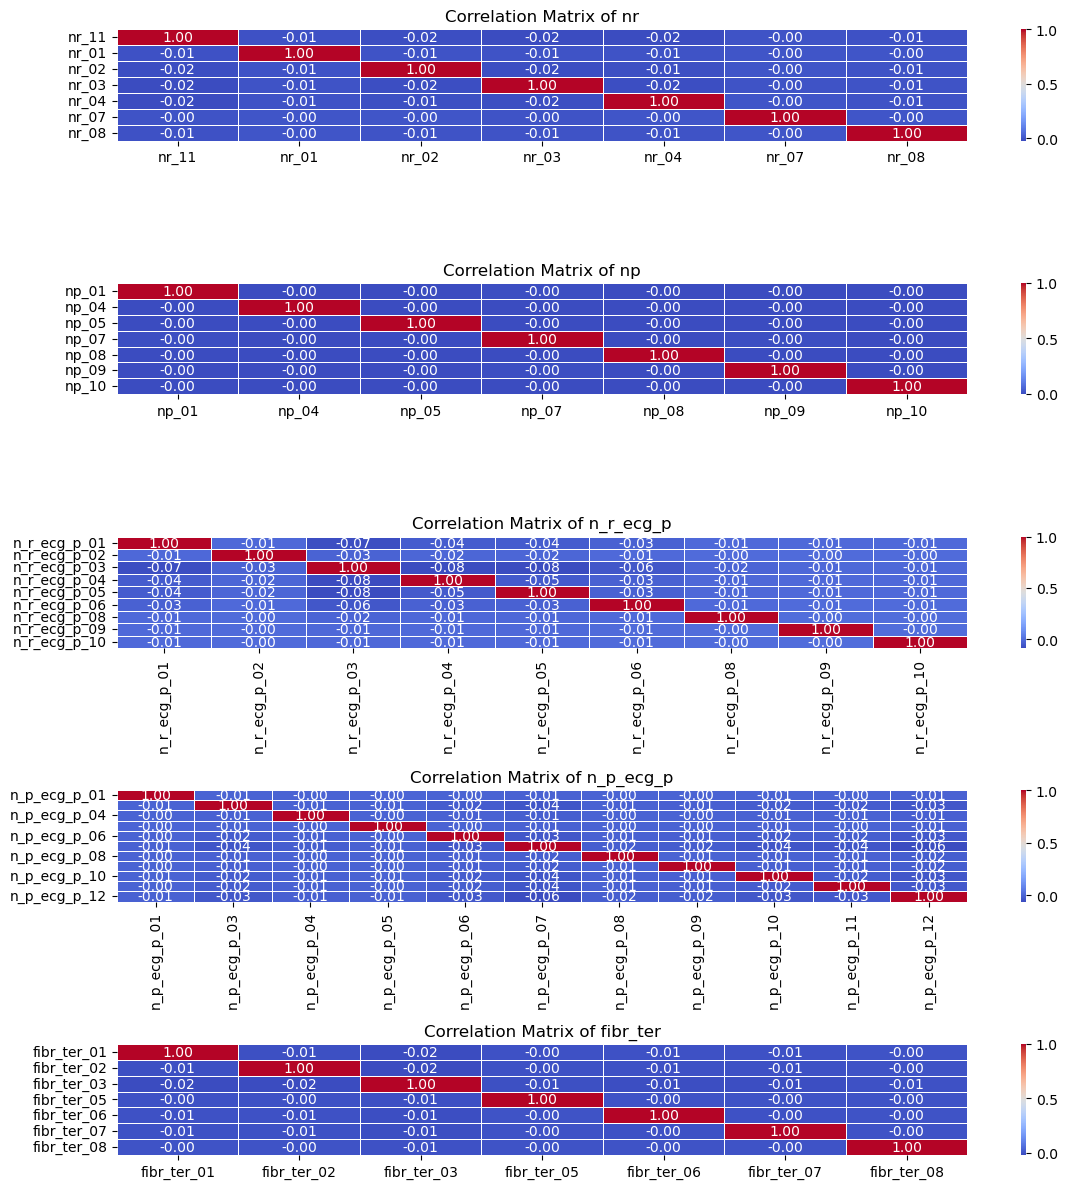

In [8]:
# Correlation heatmap for specific columns

fig, ax = plt.subplots(5, 1, figsize=(12, 12))

corr_matrix_nr = data[['nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08']].corr()
corr_matrix_np = data[['np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10']].corr()
corr_matrix_nrecg = data[['n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10']].corr()
corr_matrix_npecg = data[['n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12']].corr()
corr_matrix_fibr = data[['fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08']].corr()

sns.heatmap(corr_matrix_nr, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5, ax=ax[0])
ax[0].set_title("Correlation Matrix of nr")

sns.heatmap(corr_matrix_np, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5, ax=ax[1])
ax[1].set_title("Correlation Matrix of np")

sns.heatmap(corr_matrix_nrecg, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5, ax=ax[2])
ax[2].set_title("Correlation Matrix of n_r_ecg_p")

sns.heatmap(corr_matrix_npecg, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5, ax=ax[3])
ax[3].set_title("Correlation Matrix of n_p_ecg_p")

sns.heatmap(corr_matrix_fibr, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5, ax=ax[4])
ax[4].set_title("Correlation Matrix of fibr_ter")

plt.tight_layout()
plt.show()

In [9]:
# Identify columns that need may require scaling

data[['NA_R_2_n', 
      'NA_R_3_n', 
      'AGE', 
      'K_BLOOD', 
      'GIPER_NA', 
      'NA_BLOOD', 
      'ALT_BLOOD', 
      'AST_BLOOD', 
      'KFK_BLOOD', 
      'L_BLOOD', 
      'ROE', 
      'S_AD_KBRIG', 
      'D_AD_KBRIG', 
      'S_AD_ORIT', 
      'D_AD_ORIT']].mean()

NA_R_2_n        0.094221
NA_R_3_n        0.058636
AGE            61.856974
K_BLOOD         4.191422
GIPER_NA        0.022642
NA_BLOOD      136.550943
ALT_BLOOD       0.481455
AST_BLOOD       0.263717
KFK_BLOOD       2.000000
L_BLOOD         8.782914
ROE            13.444890
S_AD_KBRIG    136.907051
D_AD_KBRIG     81.394231
S_AD_ORIT     134.588276
D_AD_ORIT      82.749477
dtype: float64

<Axes: xlabel='LET_IS', ylabel='Count'>

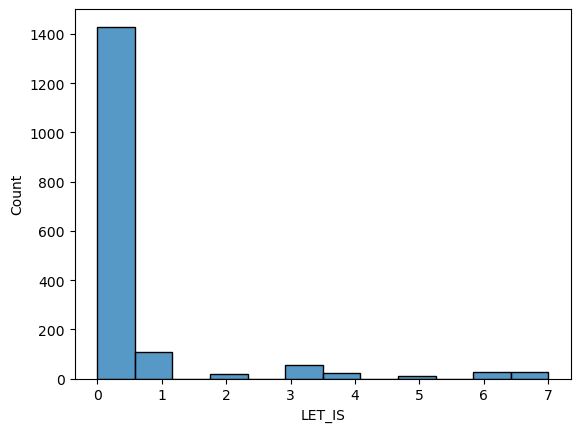

In [10]:
# Distribution of target data

sns.histplot(data['LET_IS'])

## Data Preprocessing

### Replace Missing Data

In [11]:
for col in data.columns:
    if data[col].isnull().any():
        median = data[col].median()
        data[col].fillna(median, inplace=True)

data.isnull().any()

C:\Users\HP\AppData\Local\Temp\ipykernel_18056\4087756766.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median, inplace=True)


AGE          False
SEX          False
INF_ANAM     False
STENOK_AN    False
FK_STENOK    False
             ...  
DRESSLER     False
ZSN          False
REC_IM       False
P_IM_STEN    False
LET_IS       False
Length: 123, dtype: bool

### Split X and Y Data

In [12]:
y_data = pd.DataFrame(data['LET_IS'])
x_data = data.drop('LET_IS', axis=1)

print(y_data)
print(x_data)

      LET_IS
0          0
1          0
2          0
3          0
4          0
...      ...
1695       3
1696       1
1697       6
1698       1
1699       1

[1700 rows x 1 columns]
       AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  IBS_NASL   GB  \
0     77.0    1       2.0        1.0        1.0       2.0       0.0  3.0   
1     55.0    1       1.0        0.0        0.0       0.0       0.0  0.0   
2     52.0    1       0.0        0.0        0.0       2.0       0.0  2.0   
3     68.0    0       0.0        0.0        0.0       2.0       0.0  2.0   
4     60.0    1       0.0        0.0        0.0       2.0       0.0  3.0   
...    ...  ...       ...        ...        ...       ...       ...  ...   
1695  77.0    0       0.0        4.0        2.0       1.0       0.0  2.0   
1696  70.0    0       0.0        6.0        2.0       1.0       0.0  2.0   
1697  55.0    1       3.0        6.0        2.0       2.0       0.0  0.0   
1698  79.0    0       2.0        2.0        2.0       1.0  

### Scale Data

In [13]:
scaler = StandardScaler()
x_data = pd.DataFrame(scaler.fit_transform(x_data), columns=x_data.columns)

x_data

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN
0,1.347921,0.772168,1.730224,-0.517695,-0.232308,1.069148,-0.127038,1.475882,-0.18626,1.294619,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805
1,-0.611054,0.772168,0.534054,-0.937181,-1.202636,-1.464025,-0.127038,-1.285306,-0.18626,-1.148446,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805
2,-0.878186,0.772168,-0.662115,-0.937181,-1.202636,1.069148,-0.127038,0.555486,-0.18626,-0.450427,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805
3,0.546523,-1.295054,-0.662115,-0.937181,-1.202636,1.069148,-0.127038,0.555486,-0.18626,-0.101418,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,1.820637,-0.321216,-0.308805
4,-0.165832,0.772168,-0.662115,-0.937181,-1.202636,1.069148,-0.127038,1.475882,-0.18626,1.294619,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1.347921,-1.295054,-0.662115,0.740763,0.738020,-0.197438,-0.127038,0.555486,-0.18626,1.294619,...,-0.109109,-0.159159,-0.20877,5.368851,-0.321216,5.521004,-0.214834,-0.549258,-0.321216,-0.308805
1696,0.724611,-1.295054,-0.662115,1.579735,0.738020,-0.197438,-0.127038,0.555486,-0.18626,1.294619,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805
1697,-0.611054,0.772168,2.926393,1.579735,0.738020,1.069148,-0.127038,-1.285306,-0.18626,-1.148446,...,-0.109109,-0.159159,-0.20877,-0.186260,-0.321216,-0.181126,-0.214834,-0.549258,3.113169,-0.308805
1698,1.526010,-1.295054,1.730224,-0.098209,0.738020,-0.197438,-0.127038,0.555486,-0.18626,1.294619,...,-0.109109,-0.159159,-0.20877,-0.186260,3.113169,-0.181126,-0.214834,-0.549258,-0.321216,-0.308805


### Split Train and Test Data

In [14]:
# Ratio 80% Training and 20% Testing
x_tr, x_te, y_tr, y_te = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=22)

print(x_tr.shape)
print(x_te.shape)
print(y_tr.shape)
print(y_te.shape)

(1360, 122)
(340, 122)
(1360, 1)
(340, 1)


### Over Sample Minority Classes

(9144, 122)
(9144, 1)


<Axes: ylabel='Count'>

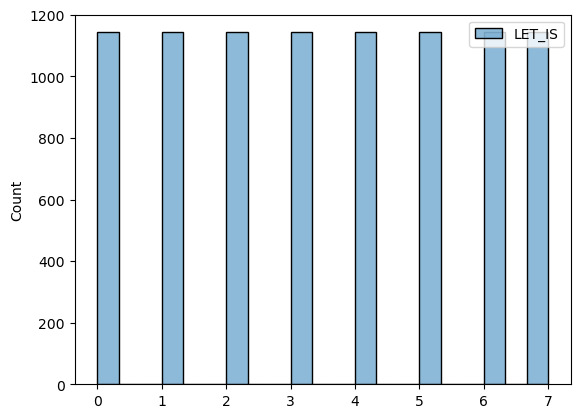

In [15]:
sm = SMOTE(random_state=22)
x_res, y_res = sm.fit_resample(x_tr, y_tr)

print(x_res.shape)
print(y_res.shape)
sns.histplot(y_res)

## Logistic Regression

### Logistic Regression (Normal Sampling)

In [16]:
# Linear Regression Model
lr_model = LogisticRegression(random_state=22)
lr_model.fit(x_tr, y_tr.values.ravel())
lr_y_pred = lr_model.predict(x_te)

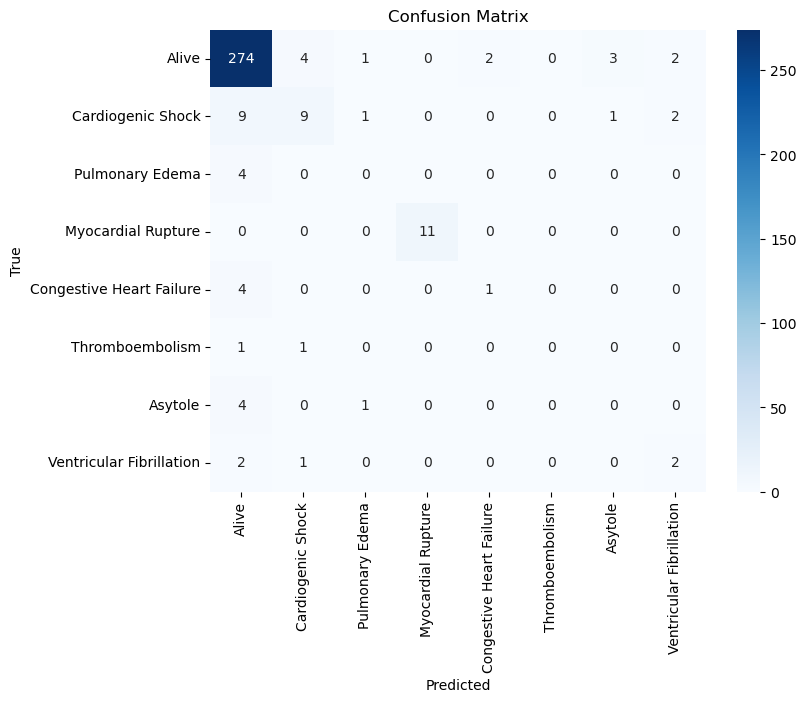

Precision of the MLP :	0.3982662192393736
Recall of the MLP    :	0.3708916083916084
F1 Score of the Model :	0.3798098768133015
Accuracy Score of the Model :	87.35%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, lr_y_pred)

### Logistic Regression (SMOTE Sampling)

In [18]:
# Linear Regression Model
lr_sm_model = LogisticRegression(random_state=22)
lr_sm_model.fit(x_res, y_res.values.ravel())
lr_sm_y_pred = lr_sm_model.predict(x_te)

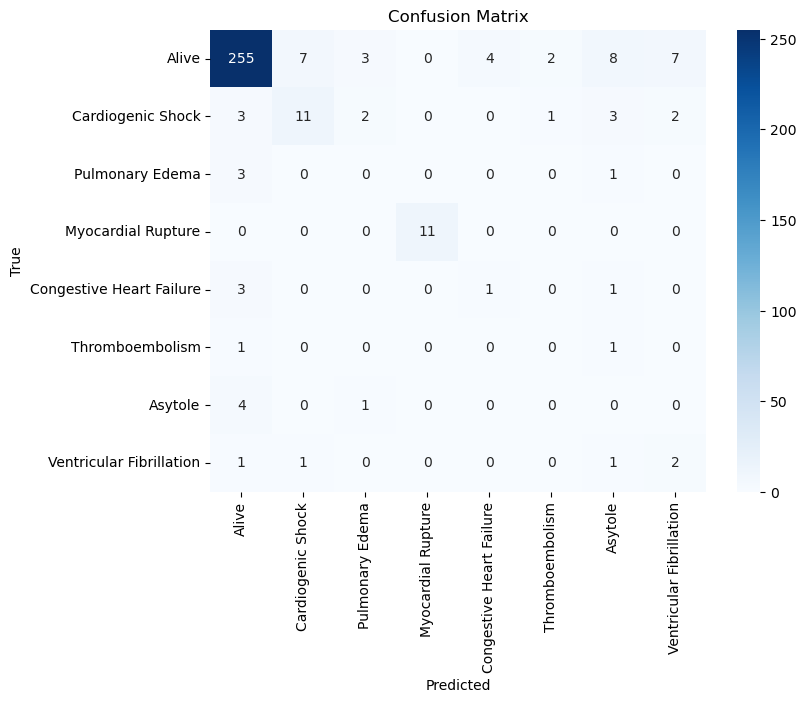

Precision of the MLP :	0.36315124933545984
Recall of the MLP    :	0.37395104895104897
F1 Score of the Model :	0.3629814441130023
Accuracy Score of the Model :	82.35%


In [19]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, lr_sm_y_pred)

## Decision Tree Classifier

### Decision Tree (Normal Sampling)

In [20]:
# Decision Tree Classifier Model
dt_model = DecisionTreeClassifier(random_state=22)
dt_model.fit(x_tr, y_tr.values.ravel())
dt_y_pred = dt_model.predict(x_te)

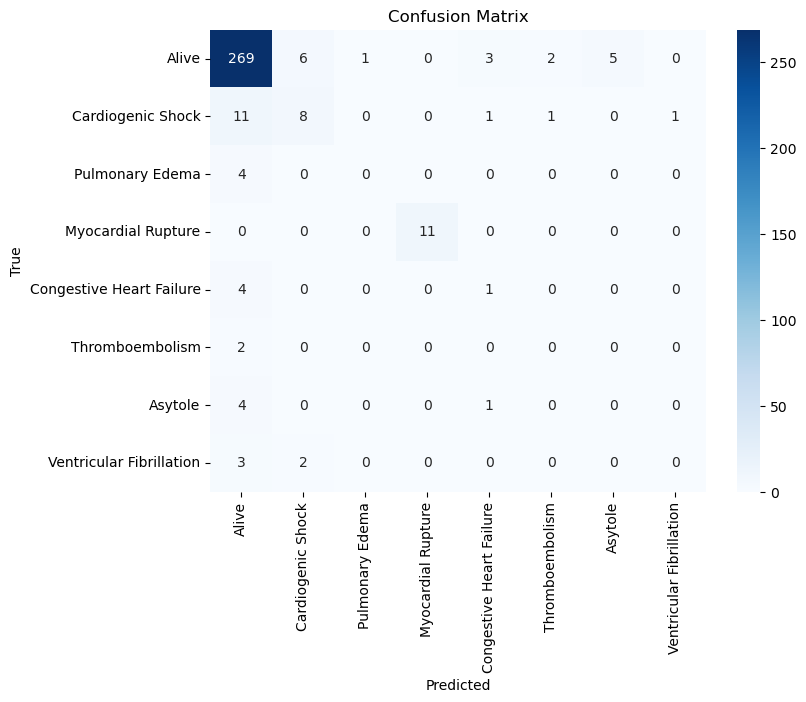

Precision of the MLP :	0.32154882154882153
Recall of the MLP    :	0.31302447552447554
F1 Score of the Model :	0.315710481177214
Accuracy Score of the Model :	85.0%


In [21]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, dt_y_pred)

### Decision Tree (SMOTE Sampling)

In [22]:
# Decision Tree Classifier Model
dt_sm_model = DecisionTreeClassifier(random_state=22)
dt_sm_model.fit(x_res, y_res.values.ravel())
dt_sm_y_pred = dt_sm_model.predict(x_te)

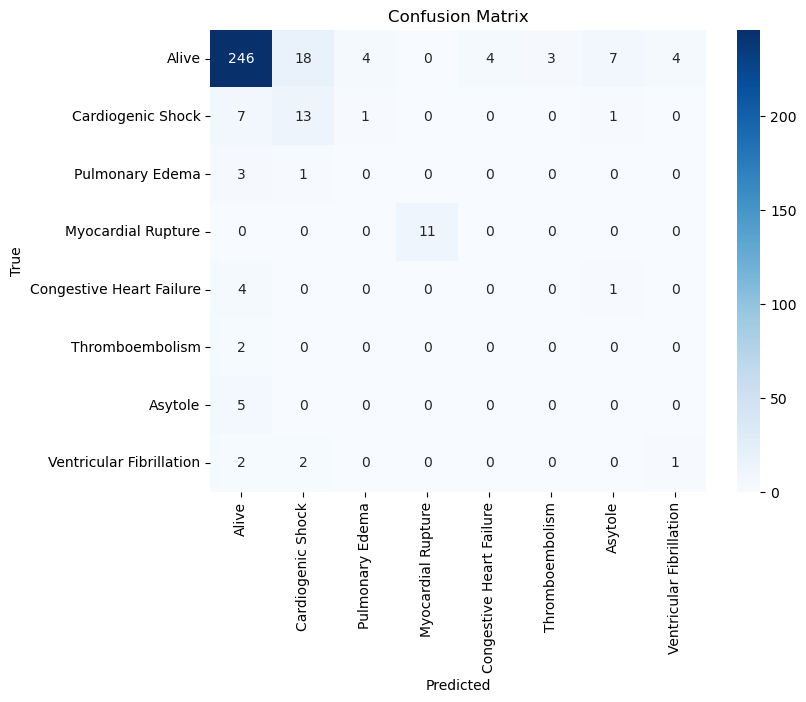

Precision of the MLP :	0.3121063853050514
Recall of the MLP    :	0.3313811188811189
F1 Score of the Model :	0.3188465250965251
Accuracy Score of the Model :	79.71%


In [23]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, dt_sm_y_pred)

### Decision Tree (Tuned for F1 Score)

In [24]:
# Create a Decision Tree Classifier and use Grid Search to find best combination of hyperparameters
dt_model_tuned = DecisionTreeClassifier(random_state=22)
dt_params = {"max_depth": [5, 10, 15, None], 
            "max_features": ["sqrt", "log2", 0.5, None],
            "min_samples_split": [2, 4, 6, 8], 
            "min_samples_leaf": [1, 2, 3, 4]}

dt_model_tuned = GridSearchCV(dt_model_tuned, dt_params, verbose=3, scoring="f1_macro")
dt_model_tuned.fit(x_res, y_res)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.403 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.486 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.523 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.502 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=0.510 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4;, score=0.403 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4;, score=0.486 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4;, score=0.523 total time=

GridSearchCV(estimator=DecisionTreeClassifier(random_state=22),
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': ['sqrt', 'log2', 0.5, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='f1_macro', verbose=3)

In [26]:
# Decision Tree Classifier Model
dt_model_tuned = DecisionTreeClassifier(random_state=22, max_features=0.5, min_samples_split=4)
dt_model_tuned.fit(x_res, y_res.values.ravel())
dt_tuned_y_pred = dt_model_tuned.predict(x_te)

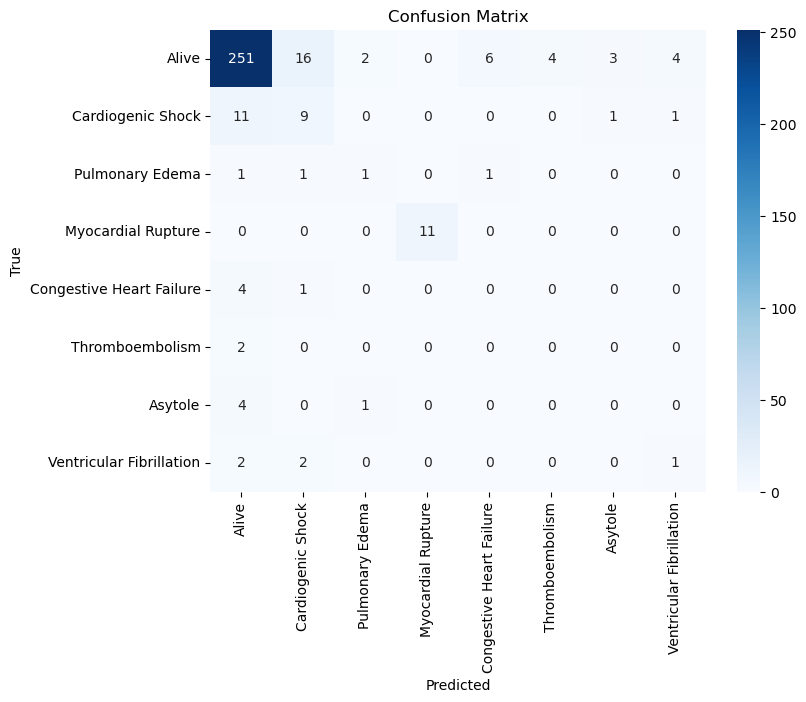

Precision of the MLP :	0.32996734587251825
Recall of the MLP    :	0.34208916083916086
F1 Score of the Model :	0.334948752228164
Accuracy Score of the Model :	80.29%


In [27]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, dt_tuned_y_pred)

## Random Forest Classifier

### Random Forest (Normal Sampling)

In [28]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=22)
rf_model.fit(x_tr, y_tr.values.ravel())
rf_y_pred = rf_model.predict(x_te)

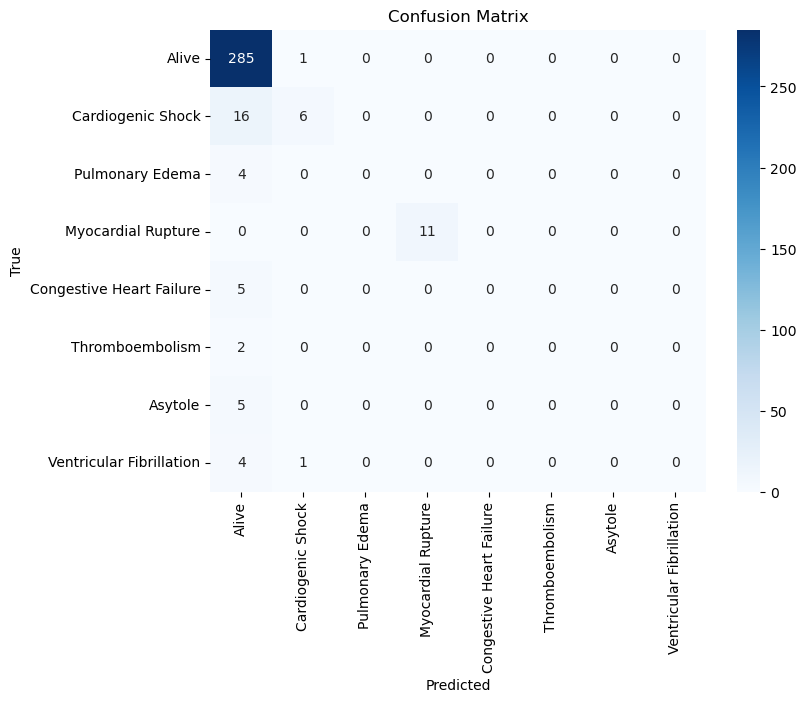

Precision of the MLP :	0.32973130841121495
Recall of the MLP    :	0.28365384615384615
F1 Score of the Model :	0.2923805601317957
Accuracy Score of the Model :	88.82%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, rf_y_pred)

### Random Forest (SMOTE Sampling)

In [30]:
# Random Forest Classifier Model
rf_sm_model = RandomForestClassifier(random_state=22)
rf_sm_model.fit(x_res, y_res.values.ravel())
rf_sm_y_pred = rf_sm_model.predict(x_te)

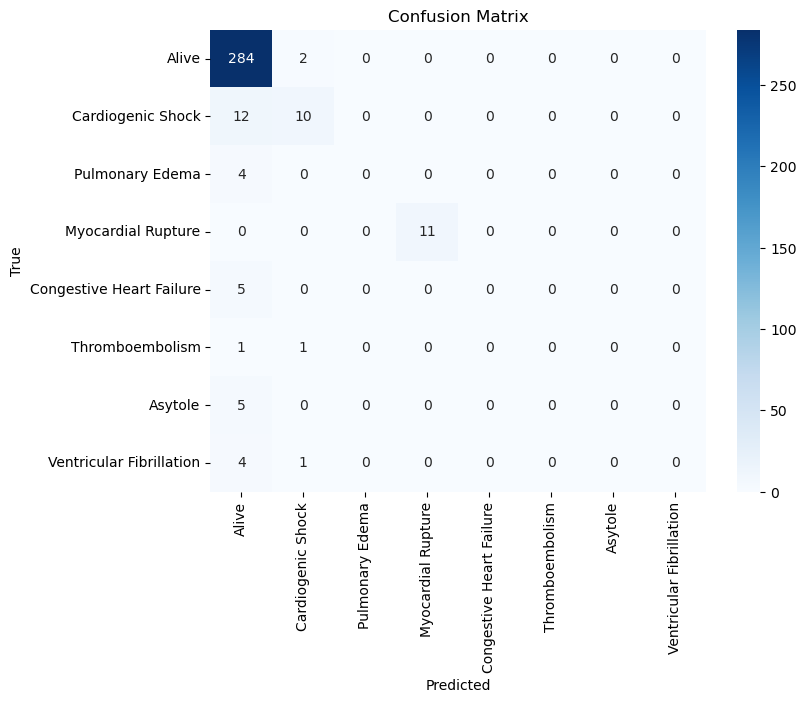

Precision of the MLP :	0.326984126984127
Recall of the MLP    :	0.30594405594405594
F1 Score of the Model :	0.3125808837123313
Accuracy Score of the Model :	89.71%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, rf_sm_y_pred)

### Balanced Random Forest

In [32]:
# Random Forest Classifier Model
brf_model = BalancedRandomForestClassifier(random_state=22)
brf_model.fit(x_tr, y_tr.values.ravel())
brf_y_pred = brf_model.predict(x_te)

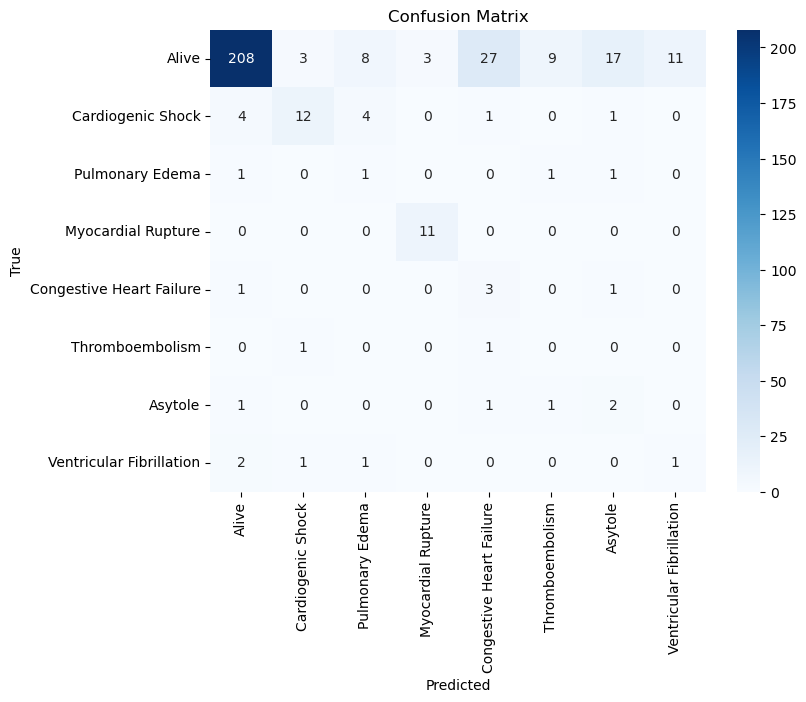

Precision of the MLP :	0.3483377588572086
Recall of the MLP    :	0.4653409090909091
F1 Score of the Model :	0.35715293045866875
Accuracy Score of the Model :	70.0%


In [33]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, brf_y_pred)

### Balanced Random Forest (Tuned for F1 Score)

In [35]:
# Create a Balanced Random Forest Classifier and use Grid Search to find best combination of hyperparameters
brf_model_tuned = BalancedRandomForestClassifier(random_state=22)
brf_params = {"n_estimators": [20, 50, 100, 200], 
              "max_features": ["sqrt", "log2", 0.5, 1],
              "max_depth": [5, 10, 15, None], 
              "min_samples_leaf": [1, 2, 3, 4]}

brf_model_tuned = GridSearchCV(brf_model_tuned, brf_params, verbose=3, scoring="f1_macro")
brf_model_tuned.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.278 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.251 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.279 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.259 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=20;, score=0.248 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.301 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.297 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.356 total time=   0.0s
[CV 4/5] END max_depth=5

GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=22),
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': ['sqrt', 'log2', 0.5, 1],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='f1_macro', verbose=3)

In [36]:
# Random Forest Classifier Model
brf_model_tuned = BalancedRandomForestClassifier(random_state=22, max_depth=10, n_estimators=200, min_samples_leaf=2)
brf_model_tuned.fit(x_tr, y_tr.values.ravel())
brf_tuned_y_pred = brf_model_tuned.predict(x_te)

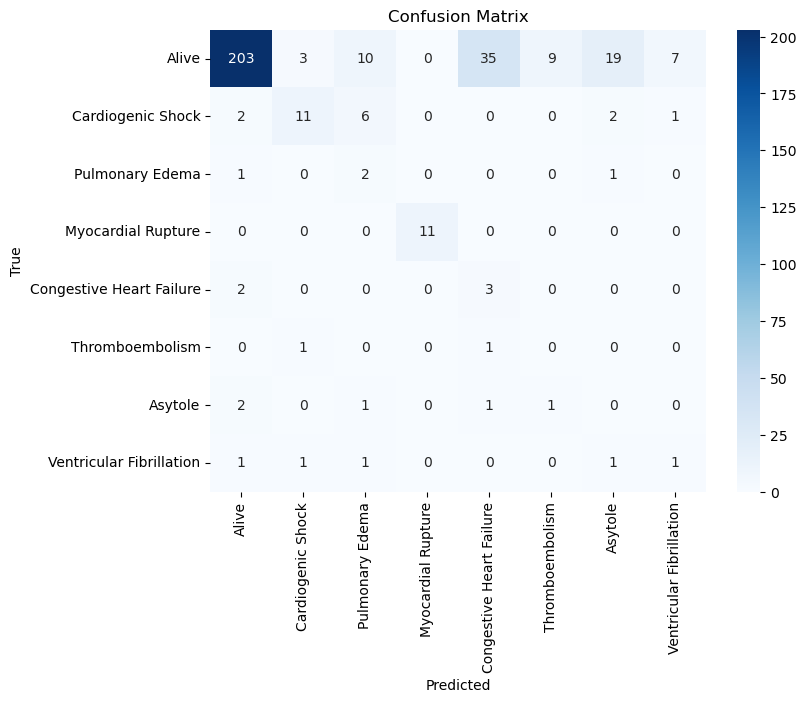

Precision of the MLP :	0.3669620523959979
Recall of the MLP    :	0.43872377622377623
F1 Score of the Model :	0.35483823996611247
Accuracy Score of the Model :	67.94%


In [37]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, brf_tuned_y_pred)

## Support Vector Classifier (SVC)

### SVC (Normal Sampling)

In [38]:
# SVC Model
svc_model = SVC(random_state=22)
svc_model.fit(x_tr, y_tr.values.ravel())
svc_y_pred = svc_model.predict(x_te)

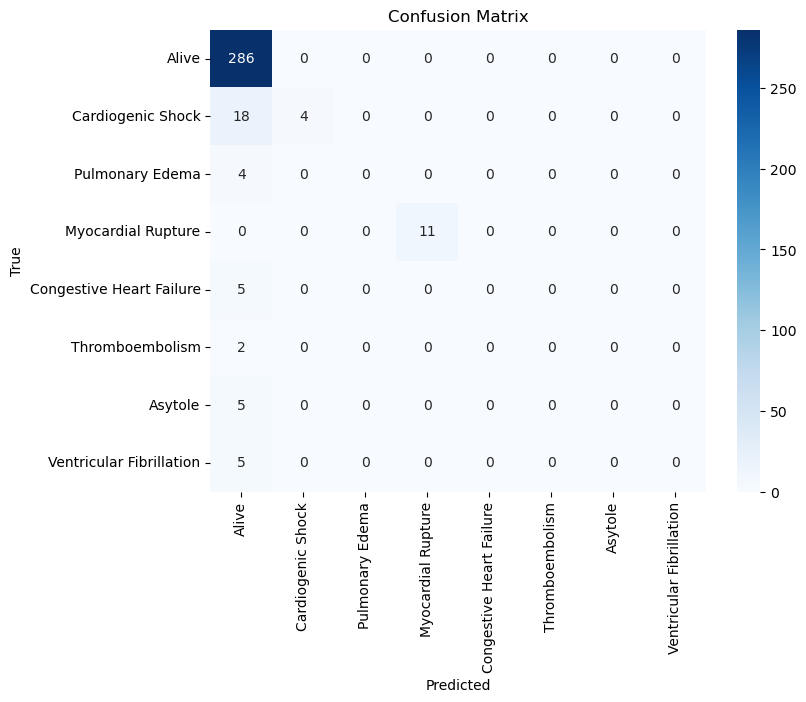

Precision of the MLP :	0.36
Recall of the MLP    :	0.2727272727272727
F1 Score of the Model :	0.2804828150572831
Accuracy Score of the Model :	88.53%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, svc_y_pred)

### SVC (SMOTE Sampling)

In [40]:
# SVC Model
svc_sm_model = SVC(random_state=22)
svc_sm_model.fit(x_res, y_res.values.ravel())
svc_sm_y_pred = svc_sm_model.predict(x_te)

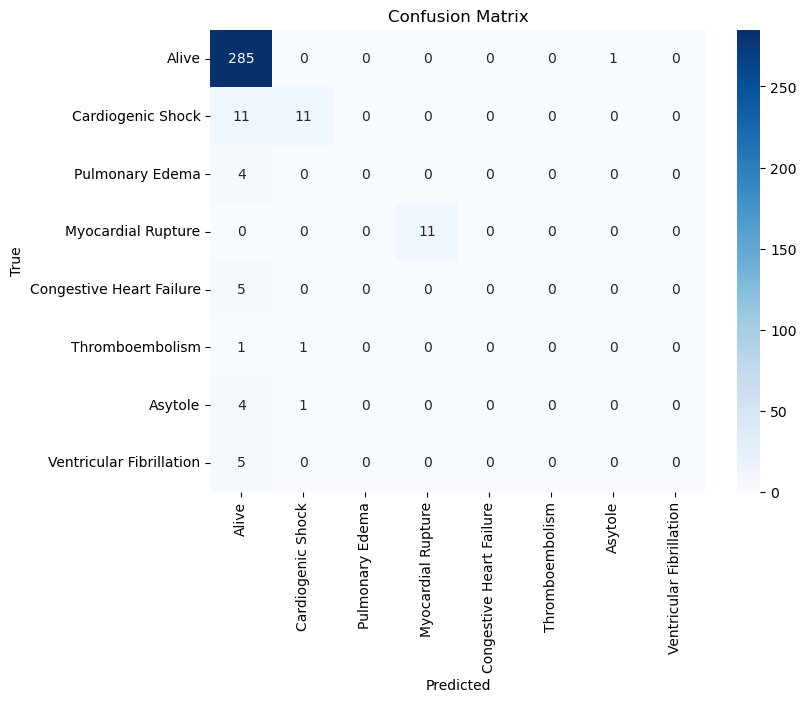

Precision of the MLP :	0.34386446886446886
Recall of the MLP    :	0.3120629370629371
F1 Score of the Model :	0.32212384121701926
Accuracy Score of the Model :	90.29%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, svc_sm_y_pred)

### SVC (Tuned for F1 Score)

In [42]:
# Create a SVC model and use Grid Search to find best combination of hyperparameters
svc_model_tuned = SVC(random_state=22)
svc_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"], 
            "degree": [0, 1, 2, 3, 6], 
            "gamma": ["scale", "auto"], 
            "C": [0.001, 0.01, 0.1, 1, 10, 100]}

svc_model_tuned = GridSearchCV(svc_model_tuned, svc_params, verbose=3, scoring="f1_macro")
svc_model_tuned.fit(x_res, y_res.values.ravel())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END C=0.001, degree=0, gamma=scale, kernel=linear;, score=0.935 total time=   1.9s
[CV 2/5] END C=0.001, degree=0, gamma=scale, kernel=linear;, score=0.942 total time=   1.9s
[CV 3/5] END C=0.001, degree=0, gamma=scale, kernel=linear;, score=0.947 total time=   1.8s
[CV 4/5] END C=0.001, degree=0, gamma=scale, kernel=linear;, score=0.922 total time=   1.9s
[CV 5/5] END C=0.001, degree=0, gamma=scale, kernel=linear;, score=0.934 total time=   1.8s
[CV 1/5] END C=0.001, degree=0, gamma=scale, kernel=poly;, score=0.028 total time=   6.0s
[CV 2/5] END C=0.001, degree=0, gamma=scale, kernel=poly;, score=0.028 total time=   6.1s
[CV 3/5] END C=0.001, degree=0, gamma=scale, kernel=poly;, score=0.028 total time=   6.2s
[CV 4/5] END C=0.001, degree=0, gamma=scale, kernel=poly;, score=0.028 total time=   6.2s
[CV 5/5] END C=0.001, degree=0, gamma=scale, kernel=poly;, score=0.028 total time=   6.1s
[CV 1/5] END C=0.001, degr

GridSearchCV(estimator=SVC(random_state=22),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'degree': [0, 1, 2, 3, 6], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=3)

In [42]:
# SVC Model
svc_model_tuned = SVC(random_state=22, C=1, degree=6, kernel='linear')
svc_model_tuned.fit(x_res, y_res.values.ravel())
svc_tuned_y_pred = svc_model_tuned.predict(x_te)

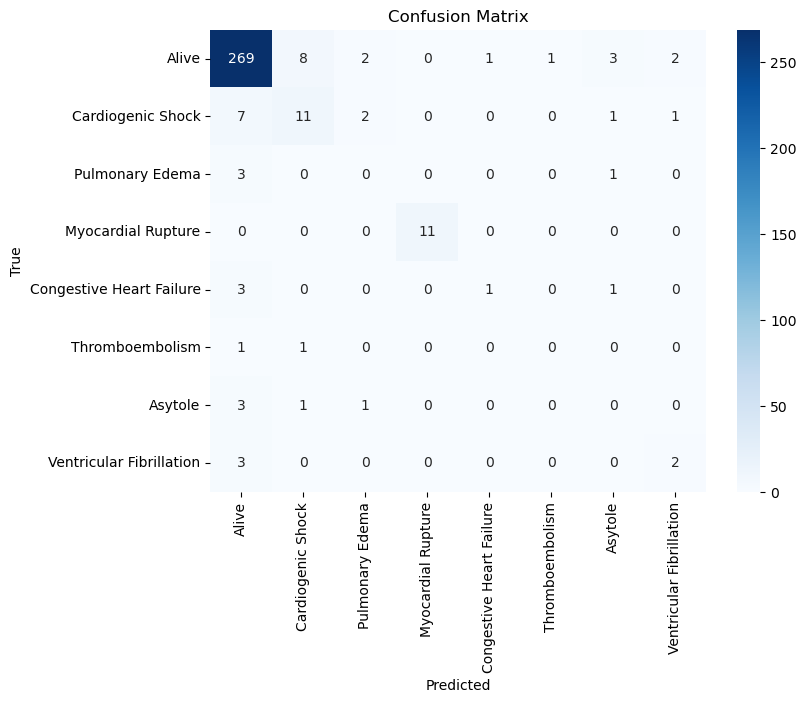

Precision of the MLP :	0.4193256714450486
Recall of the MLP    :	0.38006993006993006
F1 Score of the Model :	0.39162429582550917
Accuracy Score of the Model :	86.47%


In [43]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, svc_tuned_y_pred)

## XGB Classifier

### XGB (Normal Sampling)

In [44]:
# XGB Model
xgb_model = XGBClassifier(random_state=22)
xgb_model.fit(x_tr, y_tr.values.ravel())
xgb_y_pred = xgb_model.predict(x_te)

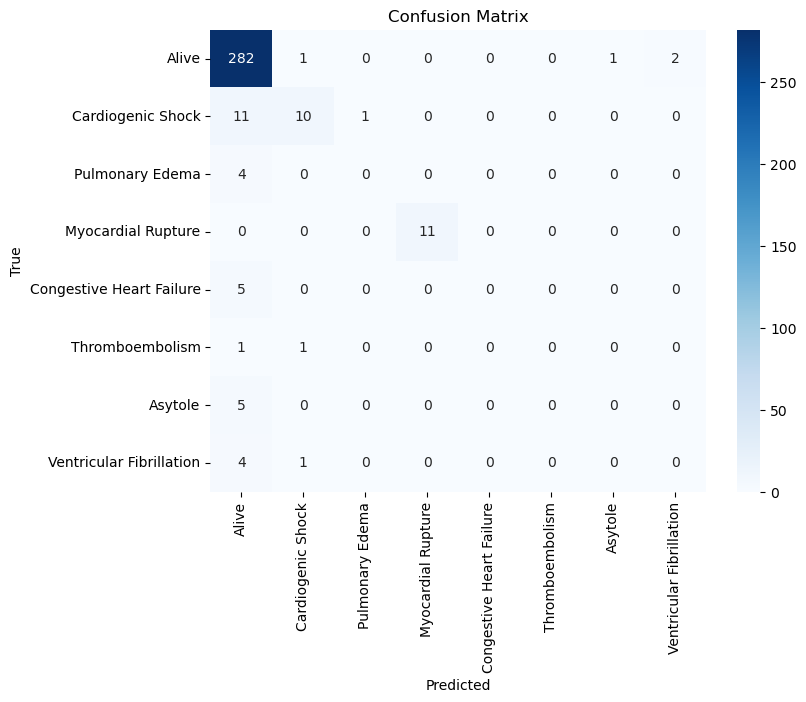

Precision of the MLP :	0.3341346153846154
Recall of the MLP    :	0.3050699300699301
F1 Score of the Model :	0.3143215480172002
Accuracy Score of the Model :	89.12%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, xgb_y_pred)

### XGB (SMOTE Sampling)

In [46]:
# XGB Model
xgb_sm_model = XGBClassifier(random_state=22)
xgb_sm_model.fit(x_res, y_res.values.ravel())
xgb_sm_y_pred = xgb_sm_model.predict(x_te)

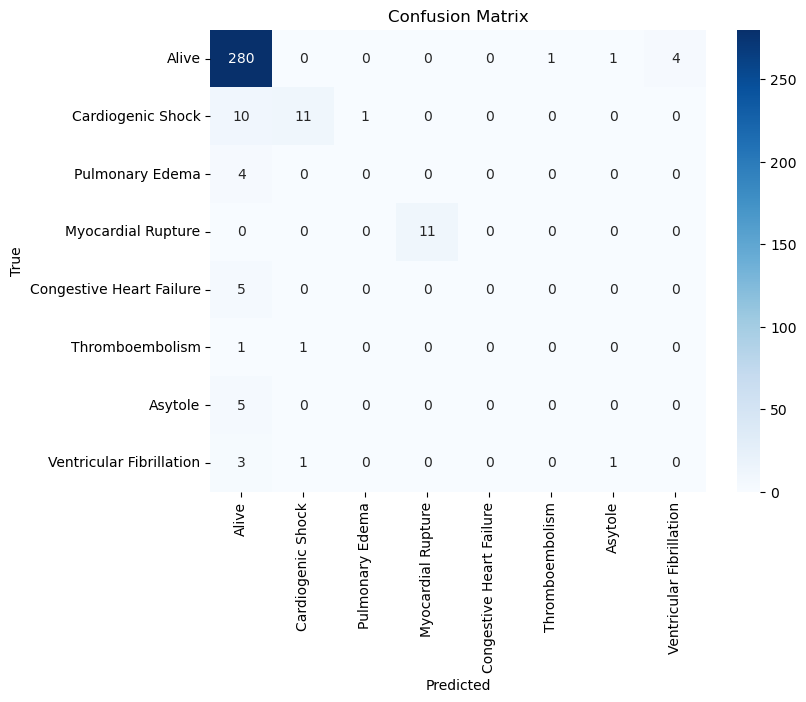

Precision of the MLP :	0.3444055944055944
Recall of the MLP    :	0.3098776223776224
F1 Score of the Model :	0.32141654641654643
Accuracy Score of the Model :	88.82%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, xgb_sm_y_pred)

### XGB (Tuned for F1 Score)

In [80]:
# Create a XGB Classifier model and use Grid Search to find best combination of hyperparameters
xgb_model_tuned = XGBClassifier(random_state=22)
xgb_params = {"n_estimators": [20, 50, 100, 200], 
              "eta": [0.01, 0.1, 0.3, 0.5],
              "max_depth": [3, 6, 9], 
              "subsample": [0.3, 0.5, 1], 
              "colsample_bytree": [0.3, 0.5, 1]}

xgb_model_tuned = GridSearchCV(xgb_model_tuned, xgb_params, verbose=3, scoring="f1_macro")
xgb_model_tuned.fit(x_res, y_res.values.ravel())
xgb_model_tuned.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.3;, score=0.892 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.3;, score=0.920 total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.3;, score=0.915 total time=   0.3s
[CV 4/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.3;, score=0.899 total time=   0.2s
[CV 5/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.3;, score=0.903 total time=   0.2s
[CV 1/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.5;, score=0.894 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsample=0.5;, score=0.925 total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, eta=0.01, max_depth=3, n_estimators=20, subsamp

{'colsample_bytree': 0.5,
 'eta': 0.01,
 'max_depth': 9,
 'n_estimators': 200,
 'subsample': 1}

In [48]:
# XGB Model
xgb_model_tuned = XGBClassifier(random_state=22, colsample_bytree=0.5, eta=0.01, max_depth=9, n_estimators=200, subsample=1)
xgb_model_tuned.fit(x_res, y_res.values.ravel())
xgb_tuned_y_pred = xgb_model_tuned.predict(x_te)

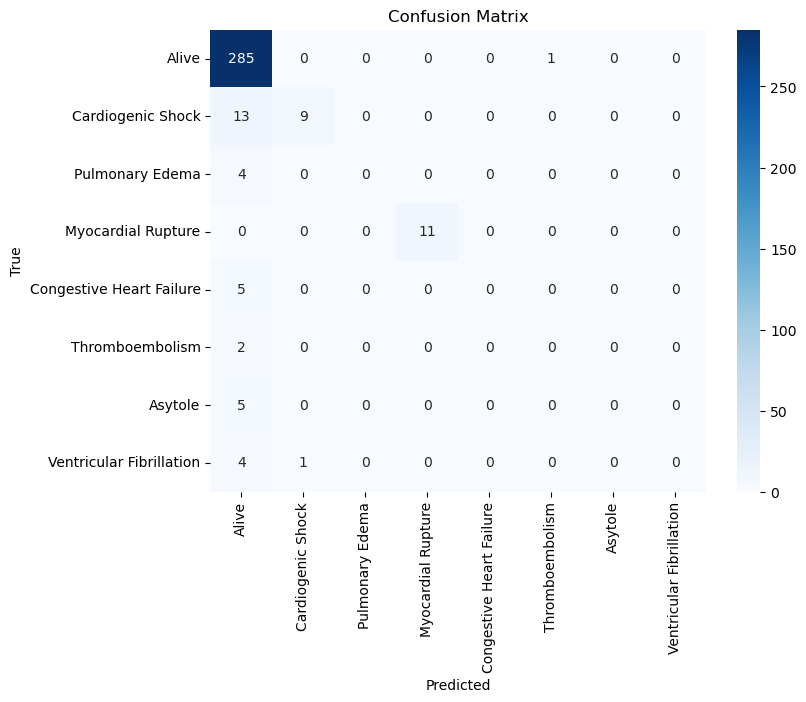

Precision of the MLP :	0.34952830188679246
Recall of the MLP    :	0.30069930069930073
F1 Score of the Model :	0.3132760761589404
Accuracy Score of the Model :	89.71%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
# Model Evaluation
confusion_matrix_and_metrics(y_te, xgb_tuned_y_pred)

## Model Comparison

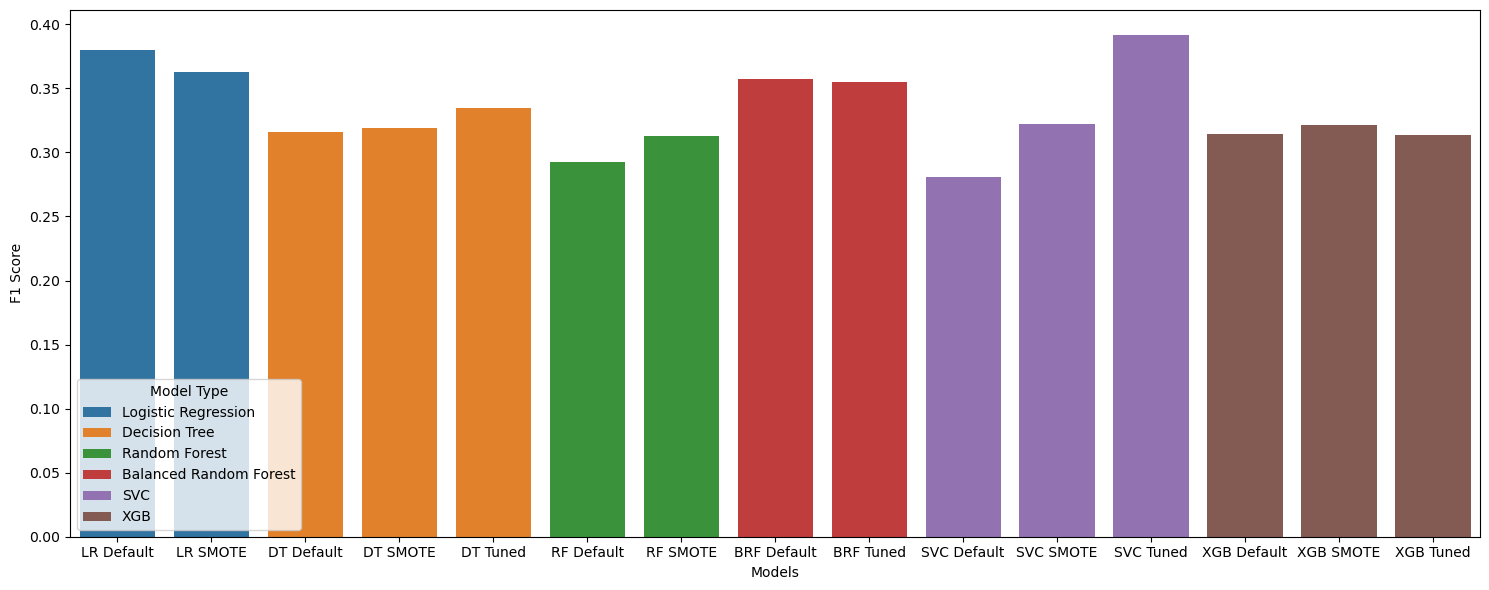

In [50]:
models = ["LR Default", 
              "LR SMOTE", 
              "DT Default", 
              "DT SMOTE", 
              "DT Tuned", 
              "RF Default", 
              "RF SMOTE",
              "BRF Default", 
              "BRF Tuned", 
              "SVC Default", 
              "SVC SMOTE", 
              "SVC Tuned", 
              "XGB Default", 
              "XGB SMOTE", 
              "XGB Tuned"]

scores = [f1_score(y_te, lr_y_pred, average="macro"), 
              f1_score(y_te, lr_sm_y_pred, average="macro"), 
              f1_score(y_te, dt_y_pred, average="macro"), 
              f1_score(y_te, dt_sm_y_pred, average="macro"), 
              f1_score(y_te, dt_tuned_y_pred, average="macro"), 
              f1_score(y_te, rf_y_pred, average="macro"), 
              f1_score(y_te, rf_sm_y_pred, average="macro"), 
              f1_score(y_te, brf_y_pred, average="macro"), 
              f1_score(y_te, brf_tuned_y_pred, average="macro"), 
              f1_score(y_te, svc_y_pred, average="macro"), 
              f1_score(y_te, svc_sm_y_pred, average="macro"), 
              f1_score(y_te, svc_tuned_y_pred, average="macro"), 
              f1_score(y_te, xgb_y_pred, average="macro"), 
              f1_score(y_te, xgb_sm_y_pred, average="macro"), 
              f1_score(y_te, xgb_tuned_y_pred, average="macro")]

model_type = ["Logistic Regression", "Logistic Regression", 
          "Decision Tree", "Decision Tree", "Decision Tree", 
          "Random Forest", "Random Forest", 
          "Balanced Random Forest", "Balanced Random Forest", 
          "SVC", "SVC", "SVC", 
          "XGB", "XGB", "XGB"]

comparison_data = pd.DataFrame({"Model Type": model_type, "F1 Score": scores, "Models": models})

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="Models", y="F1 Score", data=comparison_data, hue="Model Type", ax=ax)
sns.move_legend(ax, "lower left")
plt.tight_layout()
plt.show()

## Discussion

For this dataset the main issue with the data was its extreme imbalance. The majority of the targeted classifying values was 0 with more then 90% of the target values being 0 out of the 8 values. In an attempt to counter this imbalanced I imposed SMOTE over sampling which created variations of the minority classes in order to even up the number of samples of each class and imposed several other techniques. In general the models trained with SMOTE sampling had slightly increased F1 scores with around a 4% increase. I used F1 scoring because it better shows accuracies in imbalanced datasets. I also attempted to tune the models with the higher F1 score leading to mixed results with the majority of models doing worse then their untuned counterparts. The Grid Search also seemed to be inaccurate when grading with F1 scoring as I tuned certain models with my own hyperparameters leading them to have higher results such as with the SVC tuned model then if I used the Grid Seach recommended hyperparameters. Overall, the SVC tuned model with SMOTE sampling performed the best with around 41% F1 score. This model is the closest to having an adequate F1 score which would be a range of 50% to 70%. However, it still didn't reach this threshold so I wouldn't consider the model very useful in its current state. For the future, I would try more hyperparameter analysis to improve F1 score since my own hyperparameter choices appeared to have the best results. I would also try garnering more data as the dataset currently is difficult to model with so little samples in the other classes.

## References

1. Medium: Imbalanced Data Best Practices
2. Imbalanced Learn: Balanced Random Forest Classifier Documentation
3. Imbalanced Learn: Over Sampling and Under Sampling Documentation
4. Scikit Learn: Grid Search CV Scoring Parameter Documentation

https://rihab-feki.medium.com/imbalanced-data-best-practices-f3b6d0999f38

https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

https://imbalanced-learn.org/stable/over_sampling.html

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter